In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
from numdifftools import Jacobian
from sklearn.metrics import mean_absolute_percentage_error

In [324]:
alpha = np.random.random()
betta = np.random.random()
print('alpha=' + str(alpha) + ' betta=' + str(betta))

alpha=0.3649473123115974 betta=0.8885472851950773


In [329]:
noisy_x = [k/100 for k in range(100)]
noisy_x = np.array(list(noisy_x))
noisy_x[:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

In [330]:
noisy_y = alpha*noisy_x + betta + np.random.normal(0, 1, size=len(noisy_x))
noisy_y[:5]

array([-0.42505971, -0.08155753, -0.19428572,  0.40107583, -1.70140076])

In [331]:
def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

In [332]:
def approximate(func, coef, predictors=noisy_x, target=noisy_y):
    return np.sum((func(predictors, coef[0], coef[1]) - target) ** 2)

### f'(x) = lim (f(x+dx) - f(x))/dx

# Linear

In [336]:
def gradient_descend(a,b, function,step = 1e-3):
    # return function, a, b, iters
    counter = 0
    while True:
        a_new = a - step * ( approximate(function, coef=(a+1e-8, b)) - approximate(function, coef=(a, b))) / 1e-8
        b_new = b - step * ( approximate(function, coef=(a, b+1e-8)) - approximate(function, coef=(a, b))) / 1e-8
        f_new = approximate(function, coef=(a_new, b_new))
        f_old = approximate(function, coef=(a,b))
        if np.abs(f_old - f_new) >= 1e-8:
            counter += 1
            a = a_new
            b = b_new
        else:
            return {'function': f_old,
                    'a': a,
                    'b': b,
                    'iter': counter}

In [337]:
print(gradient_descend(0.2, 0.8, linear))

{'function': 100.18126848824036, 'a': 0.5192593339917948, 'b': 0.7587088097996457, 'iter': 537}


In [338]:
aprox_min = lambda x: approximate(linear, coef=x)
cg_lin = minimize(aprox_min, x0=(0,0), method='CG')
print(cg_lin)

     fun: 100.18126810807503
     jac: array([9.53674316e-07, 0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 2
    njev: 5
  status: 0
 success: True
       x: array([0.51947141, 0.75859642])


In [339]:
jacobian_lin = lambda x: Jacobian(aprox_min)(x).ravel()
newton_cg = minimize(aprox_min, x0=[(0,0)], method="Newton-CG", jac=jacobian_lin)
print(newton_cg)

     fun: 100.181268108075
     jac: array([-0.00069321,  0.0003727 ])
 message: "Warning: CG iterations didn't converge. The Hessian is not positive definite."
    nfev: 5
    nhev: 0
     nit: 4
    njev: 90
  status: 3
 success: False
       x: array([0.51947136, 0.75859644])


In [340]:
def approximate_lm(coef,func, predictors=noisy_x, target=noisy_y):
    return np.sum(((func(predictors, coef[0], coef[1]) - target) ** 2)), 0

In [341]:
lm_l = least_squares(approximate_lm, x0=(0,0),args=(linear,), method='lm')
print(np.sum(lm_l.fun))

100.18126954431678


In [342]:
print(lm_l)

 active_mask: array([0, 0])
        cost: 5018.143383755526
         fun: array([100.18126954,   0.        ])
        grad: array([-0.5767203,  0.2288099])
         jac: array([[-0.00575677,  0.00228396],
       [ 0.        ,  0.        ]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 164
        njev: None
  optimality: 0.5767202997684715
      status: 2
     success: True
           x: array([0.5190581 , 0.75881243])


# Rational

In [343]:
print(gradient_descend(0, 0, rational, step=1e-4))

{'function': 100.978345079501, 'a': 0.8696386025519587, 'b': -0.27959044402336986, 'iter': 1392}


In [344]:
aprox_min_r = lambda x: approximate(rational, coef=x)
cg_r = minimize(aprox_min_r, x0=(0,0),method='CG')
print(cg_r)

     fun: 100.978343729478
     jac: array([9.53674316e-07, 9.53674316e-07])
 message: 'Optimization terminated successfully.'
    nfev: 69
     nit: 11
    njev: 23
  status: 0
 success: True
       x: array([ 0.86948523, -0.27981296])


In [345]:
jacobian_r = lambda x: Jacobian(aprox_min_r)(x).ravel()
newton_cg_r = minimize(aprox_min_r, x0=[(0,0)], method="Newton-CG", jac=jacobian_r)
print(newton_cg_r)

     fun: 100.97834372947919
     jac: array([4.51948104e-05, 2.11141066e-05])
 message: 'Optimization terminated successfully.'
    nfev: 8
    nhev: 0
     nit: 6
    njev: 28
  status: 0
 success: True
       x: array([ 0.86948534, -0.27981277])


In [346]:
def approximate_lm_r(coef, func, predictors=noisy_x, target=noisy_y):
    return np.sum((func(predictors, coef[0], coef[1]) - target) ** 2), 0


lm_r = least_squares(approximate_lm_r, x0=(0, 0), args=(rational,), method='lm')
print(np.sum(lm_r.fun))

100.97834379477226


In [347]:
print(lm_r)

 active_mask: array([0, 0])
        cost: 5098.312957767611
         fun: array([100.97834379,   0.        ])
        grad: array([-0.37942161,  0.43238862])
         jac: array([[-0.00375746,  0.00428199],
       [ 0.        ,  0.        ]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 70
        njev: None
  optimality: 0.43238861562683417
      status: 2
     success: True
           x: array([ 0.86949496, -0.27977394])


# Graphs Linear

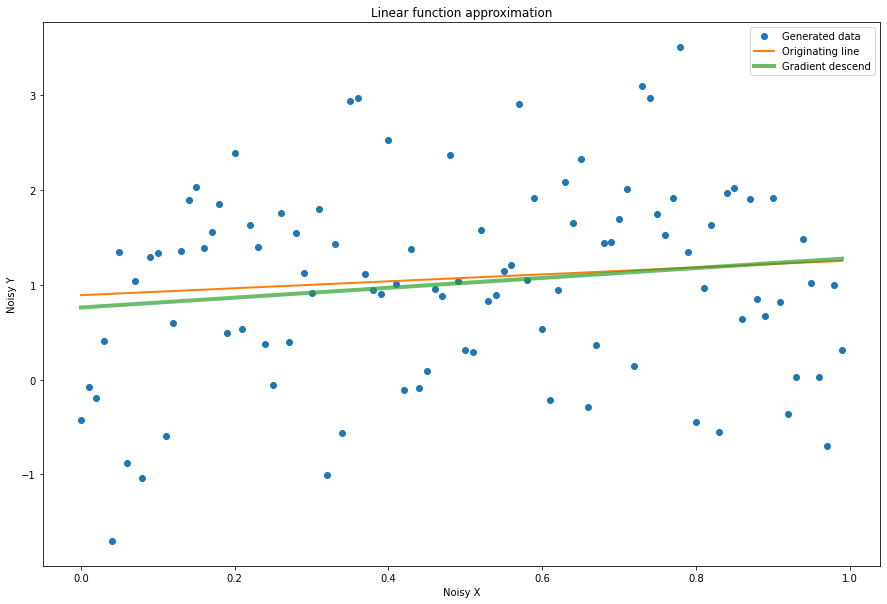

In [348]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, linear(noisy_x, a=gradient_descend(0, 0, linear)['a'], b=gradient_descend(0, 0, linear)['b']) , linewidth=4, alpha=0.7,
         label="Gradient descend")
plt.title('Linear function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_Linear_approx_grad_d', bbox_inches='tight')
plt.show()

In [349]:
mape_gd_l = mean_absolute_percentage_error(linear(noisy_x, a=alpha, b=betta), linear(noisy_x, a=gradient_descend(0, 0, linear)['a'], b=gradient_descend(0, 0, linear)['b']))
mape_gd_l

0.05761816925581293

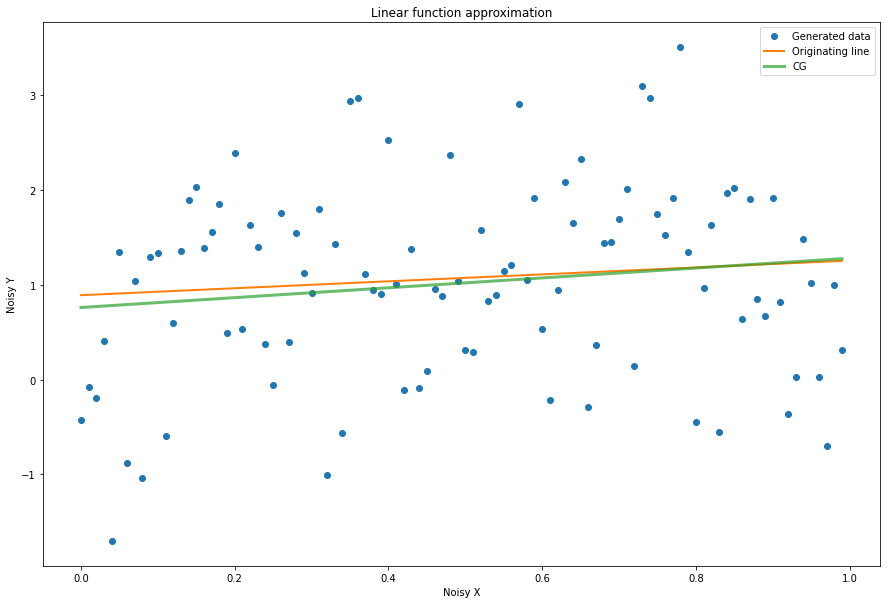

In [350]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, linear(noisy_x, a=cg_lin.x[0], b=cg_lin.x[1]), linewidth=3, alpha=0.7,
         label="CG")
plt.title('Linear function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_Linear_approx_CG', bbox_inches='tight')
plt.show()

In [351]:
mape_cg_l = mean_absolute_percentage_error(linear(noisy_x, a=alpha, b=betta), linear(noisy_x, a=cg_lin.x[0], b=cg_lin.x[1]))
mape_cg_l

0.05765101811822552

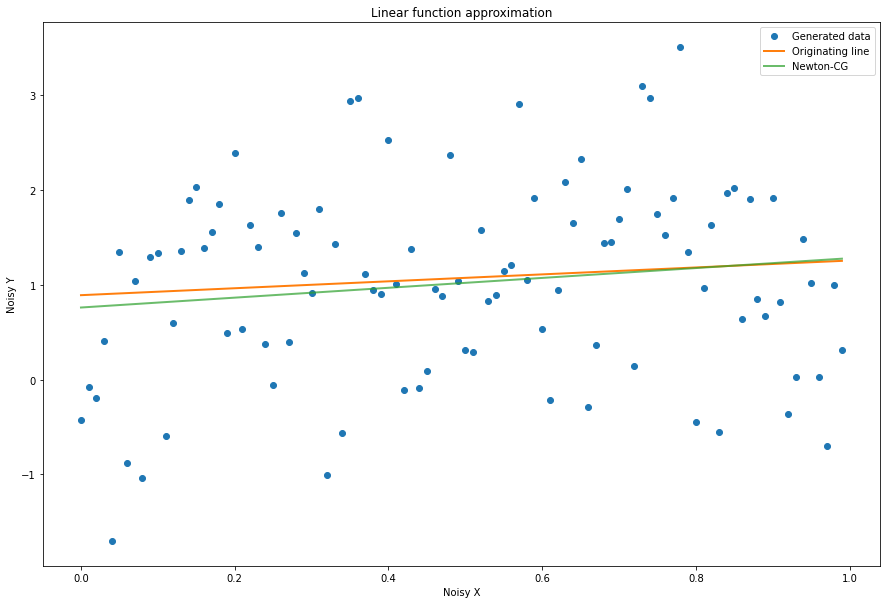

In [352]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, linear(noisy_x, a=newton_cg.x[0], b=newton_cg.x[1]), linewidth=2, alpha=0.7,
         label="Newton-CG")
plt.title('Linear function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_Linear_approx_newton', bbox_inches='tight')
plt.show()

In [353]:
mape_newton_l = mean_absolute_percentage_error(linear(noisy_x, a=alpha, b=betta), linear(noisy_x, a=newton_cg.x[0], b=newton_cg.x[1]))
mape_newton_l

0.0576510104204071

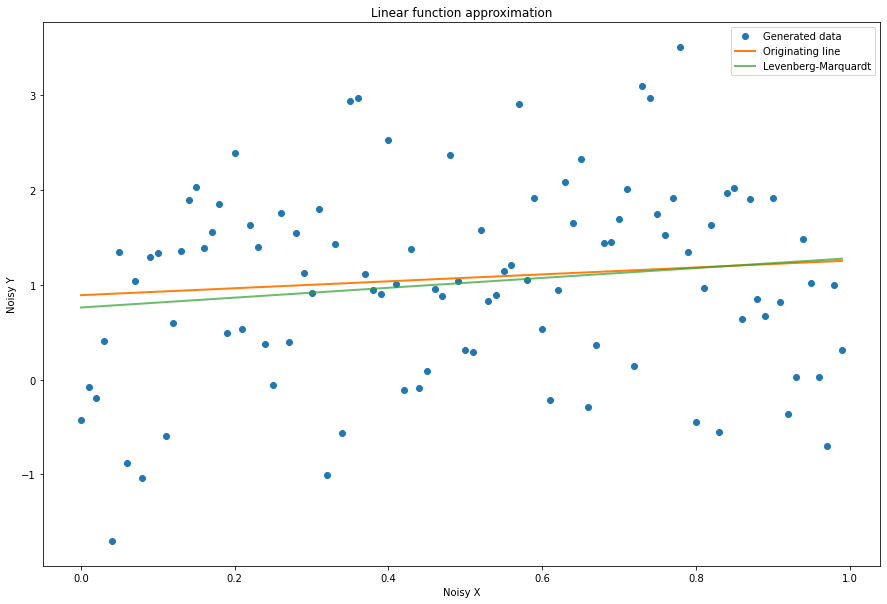

In [354]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, linear(noisy_x, a=lm_l.x[0], b=lm_l.x[1]), linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt")
plt.title('Linear function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_Linear_approx_lm', bbox_inches='tight')
plt.show()

In [355]:
mape_lm_l = mean_absolute_percentage_error(linear(noisy_x, a=alpha, b=betta), linear(noisy_x, a=lm_l.x[0], b=lm_l.x[1]) )
mape_lm_l

0.05758884625752729

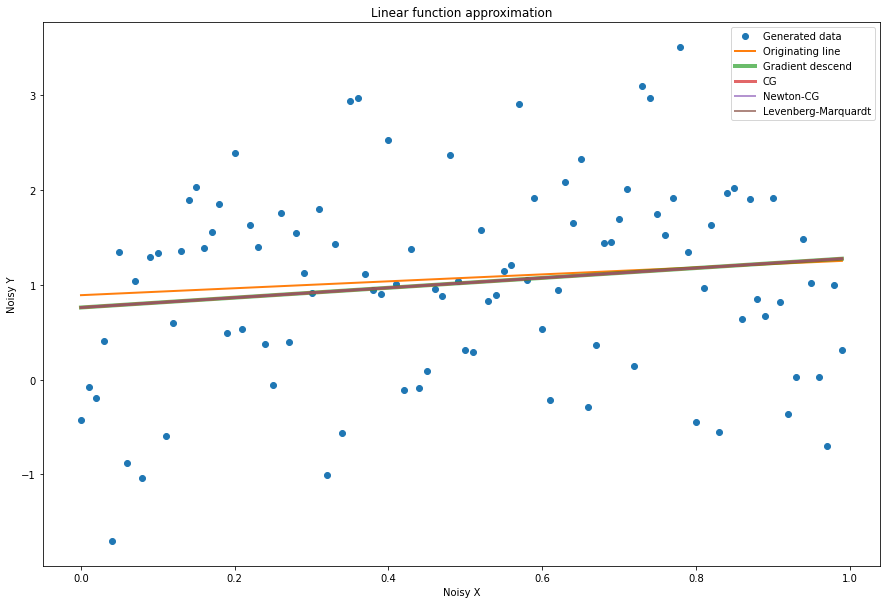

In [379]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, linear(noisy_x, a=gradient_descend(0, 0, linear)['a'], b=gradient_descend(0, 0, linear)['b']) , linewidth=4, alpha=0.7,
         label="Gradient descend")
plt.plot(noisy_x, linear(noisy_x, a=cg_lin.x[0], b=cg_lin.x[1]), linewidth=3, alpha=0.7,
         label="CG")
plt.plot(noisy_x, linear(noisy_x, a=newton_cg.x[0], b=newton_cg.x[1]), linewidth=2, alpha=0.7,
         label="Newton-CG")
plt.plot(noisy_x, linear(noisy_x, a=lm_l.x[0], b=lm_l.x[1]), linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt")
plt.title('Linear function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_Linear_approx_all', bbox_inches='tight')
plt.show()

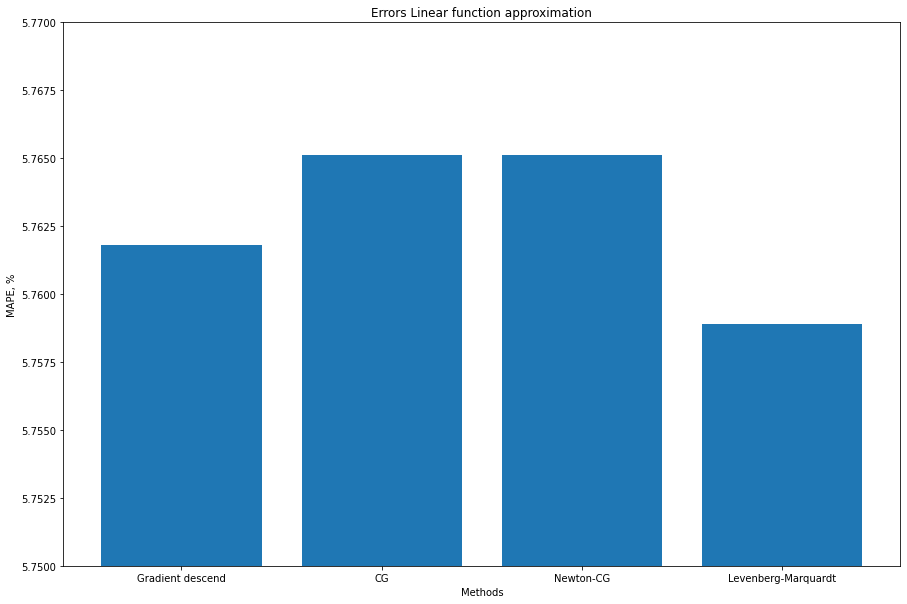

In [363]:
plt.figure(figsize=(15, 10))
x = ["Gradient descend", "CG", "Newton-CG", "Levenberg-Marquardt"]
y = list(map(lambda x: x*100, [mape_gd_l, mape_cg_l, mape_newton_l, mape_lm_l]))
plt.bar(x,y)
plt.title('Errors Linear function approximation')
plt.xlabel('Methods')
plt.ylabel('MAPE, %')
plt.ylim(5.75,5.77)
plt.savefig('./Pictures/task3_Linear_approx_MAPE', bbox_inches='tight')
plt.show()

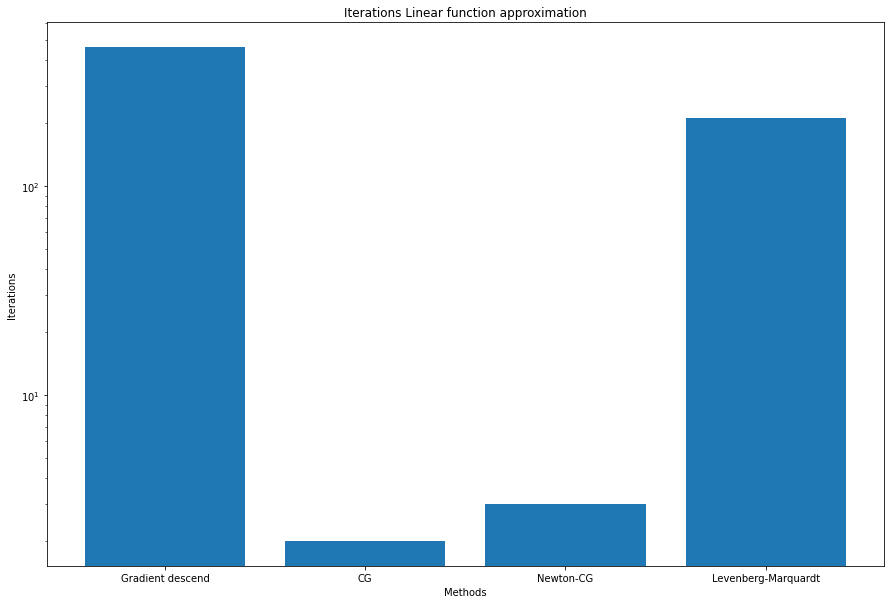

In [364]:
plt.figure(figsize=(15, 10))
x = ["Gradient descend", "CG", "Newton-CG", "Levenberg-Marquardt"]
y = [463, 2, 3, 211]
plt.bar(x,y)
plt.title('Iterations Linear function approximation')
plt.xlabel('Methods')
plt.ylabel('Iterations')
plt.yscale('log')
plt.savefig('./Pictures/task3_Linear_approx_num_iter', bbox_inches='tight')
plt.show()

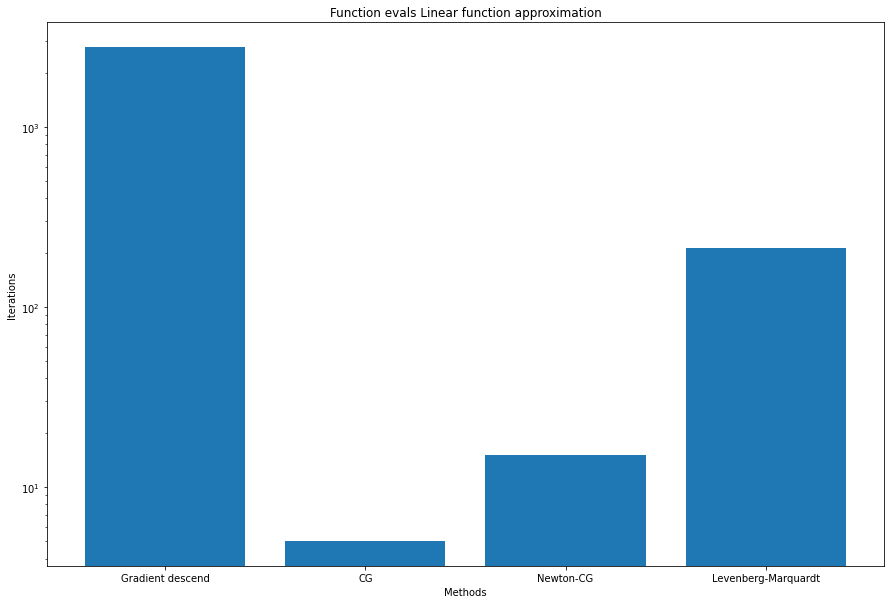

In [365]:
plt.figure(figsize=(15, 10))
x = ["Gradient descend", "CG", "Newton-CG", "Levenberg-Marquardt"]
y = [463*6, 5, 15, 211]
plt.bar(x,y)
plt.title('Function evals Linear function approximation')
plt.xlabel('Methods')
plt.ylabel('Iterations')
plt.yscale('log')
plt.savefig('./Pictures/task3_Linear_approx_num_evals', bbox_inches='tight')
plt.show()

# Graphs rational

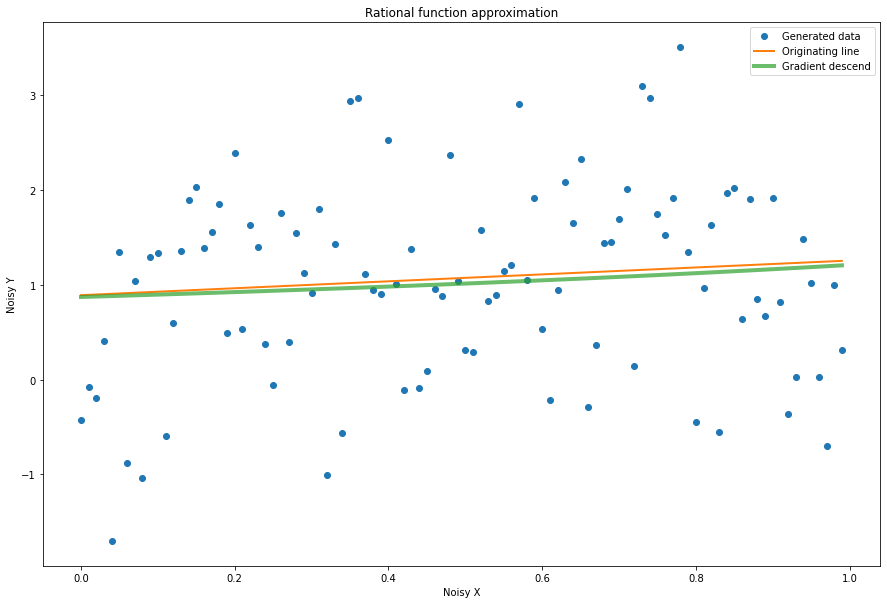

In [382]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, rational(noisy_x, a=gradient_descend(0, 0, rational)['a'], b=gradient_descend(0, 0, rational)['b']) , linewidth=4, alpha=0.7,
         label="Gradient descend")
plt.title('Rational function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_rational_approx_grad_d', bbox_inches='tight')
plt.show()

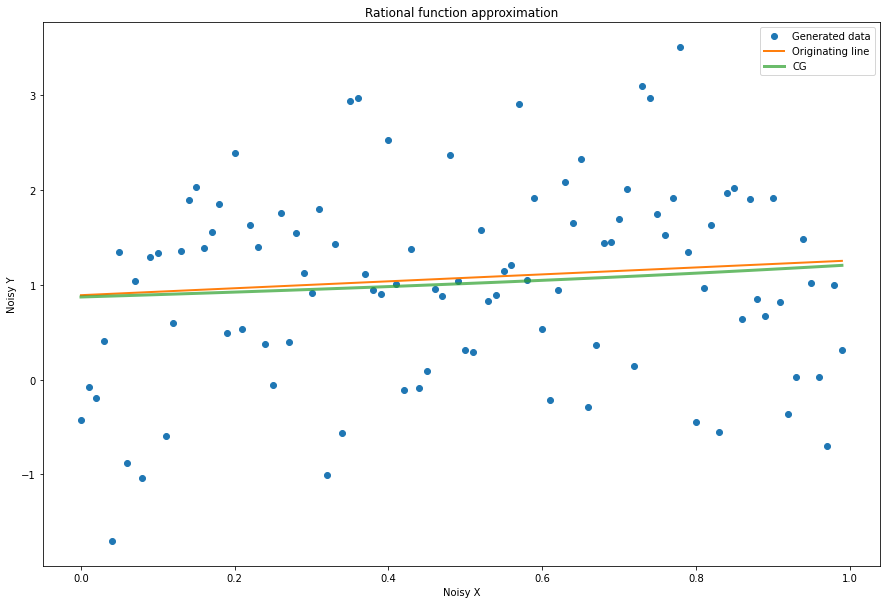

In [383]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, rational(noisy_x, a=cg_r.x[0], b=cg_r.x[1]), linewidth=3, alpha=0.7,
         label="CG")
plt.title('Rational function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_rational_approx_CG', bbox_inches='tight')
plt.show()

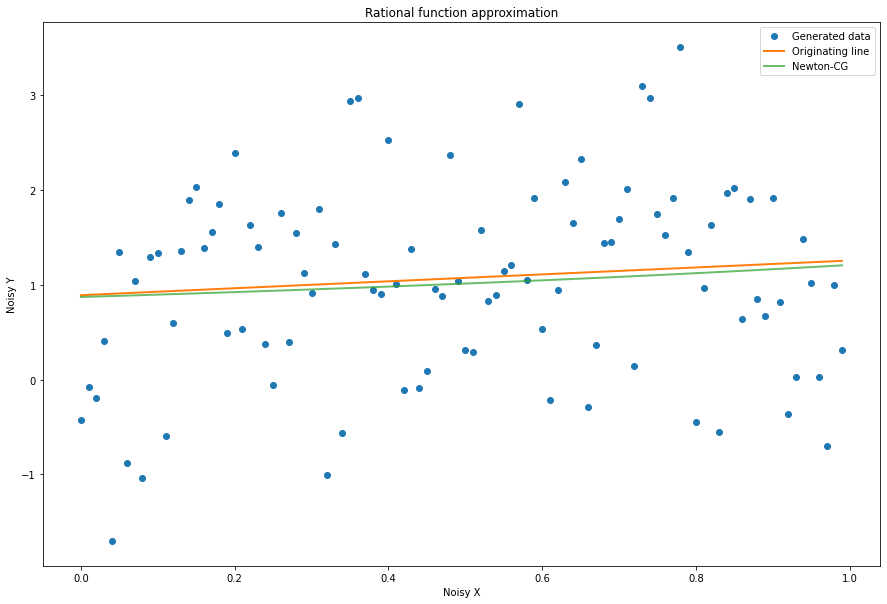

In [384]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, rational(noisy_x, a=newton_cg_r.x[0], b=newton_cg_r.x[1]), linewidth=2, alpha=0.7,
         label="Newton-CG")
plt.title('Rational function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_rational_approx_newton', bbox_inches='tight')
plt.show()

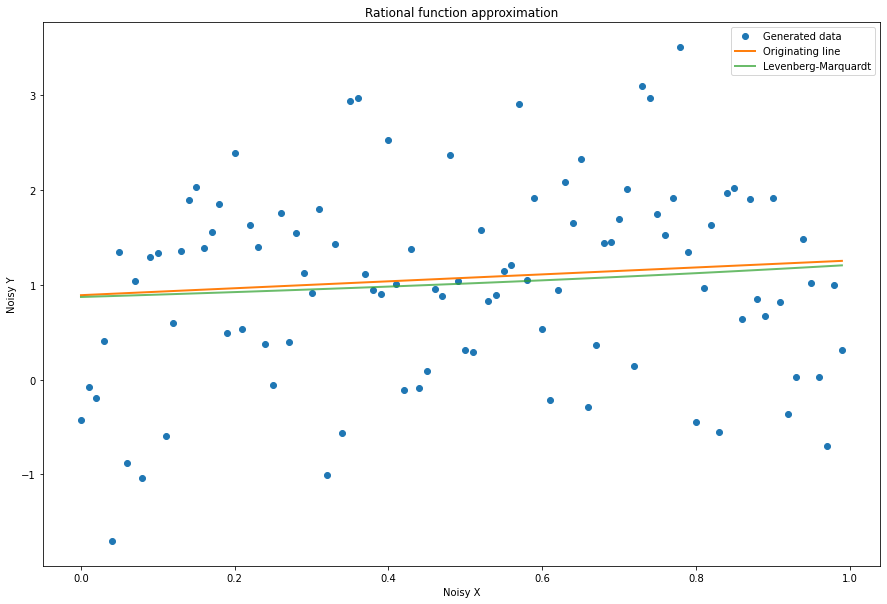

In [385]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, rational(noisy_x, a=lm_r.x[0], b=lm_r.x[1]), linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt")
plt.title('Rational function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_rational_approx_lm', bbox_inches='tight')
plt.show()

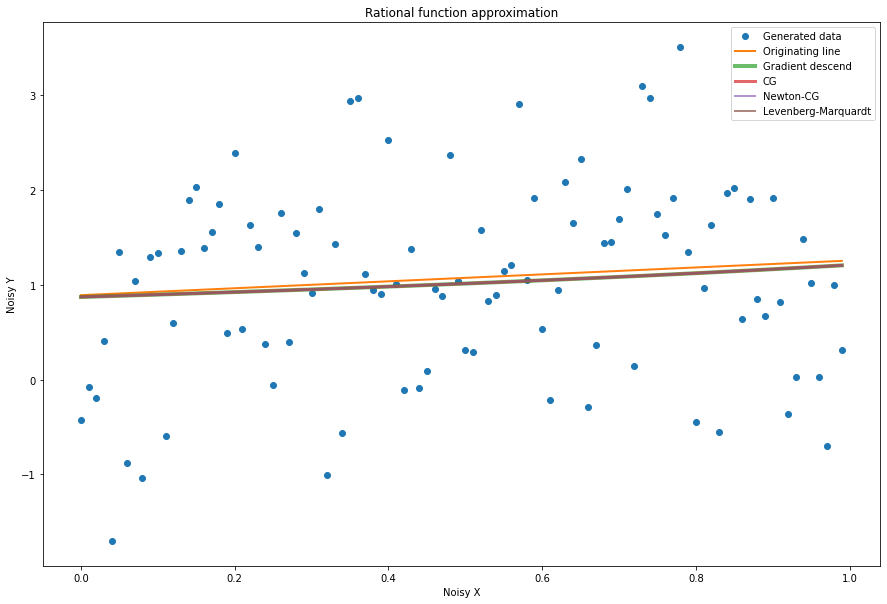

In [381]:
plt.figure(figsize=(15, 10))
plt.plot(noisy_x, noisy_y, 'o', label="Generated data")
plt.plot(noisy_x, linear(noisy_x, a=alpha, b=betta), linewidth=2, label="Originating line")
plt.plot(noisy_x, rational(noisy_x, a=gradient_descend(0, 0, rational, step=1e-4)['a'], b=gradient_descend(0, 0, rational, step=1e-4)['b']) , linewidth=4, alpha=0.7,
         label="Gradient descend")
plt.plot(noisy_x, rational(noisy_x, a=cg_r.x[0], b=cg_r.x[1]), linewidth=3, alpha=0.7,
         label="CG")
plt.plot(noisy_x, rational(noisy_x, a=newton_cg_r.x[0], b=newton_cg_r.x[1]), linewidth=2, alpha=0.7,
         label="Newton-CG")
plt.plot(noisy_x, rational(noisy_x, a=lm_r.x[0], b=lm_r.x[1]), linewidth=2, alpha=0.7,
         label="Levenberg-Marquardt")
plt.title('Rational function approximation')
plt.legend()
plt.xlabel('Noisy X')
plt.ylabel('Noisy Y')
plt.savefig('./Pictures/task3_rational_approx_all', bbox_inches='tight')
plt.show()

In [378]:
mape_gd_r = mean_absolute_percentage_error(rational(noisy_x, a=alpha, b=betta), )

TypeError: mean_absolute_percentage_error() missing 1 required positional argument: 'y_pred'

In [ ]:
plt.figure(figsize=(15, 10))
x = ["Gradient descend", "CG", "Newton-CG", "Levenberg-Marquardt"]
y = list(map(lambda x: x*100, [, mape_cg_l, mape_newton_l, mape_lm_l]))
plt.bar(x,y)
plt.title('Errors Linear function approximation')
plt.xlabel('Methods')
plt.ylabel('MAPE, %')
plt.ylim(126, 126.25)
plt.savefig('./Pictures/task3_rationa;_approx_MAPE', bbox_inches='tight')
plt.show()